In [1]:
import numpy as np
import pickle
import glob
import matplotlib.pyplot as plt

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]= "4"

from scipy.special import entr # see https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.entr.html
from keras.utils import to_categorical
import keras.metrics as metrics
from kf_impl import EKF_CV_MODEL
from lstm_impl import CombinedLSTM
import pdb
from utils import extract_data, sup_plot
import random
from tfrecord_utils import  read_tfrecord
import pandas as pd
import seaborn as sns

Using TensorFlow backend.


### Data Loading

In [2]:
def build_train_test_splits(tf_files_list, num_tf_folds=5):
    # Using a suboptimal approach here:
    # Just build a list of dictionaries, where entry_i 
    # corresponds to train split i.

    train_sets = []
    test_sets  = []
    folds  = []
    
    inds = np.arange(num_tf_folds)
    
    random.shuffle(tf_files_list)
    n_files = len(tf_files_list)
    
    
    splits = (n_files // num_tf_folds) * np.ones(num_tf_folds)
    splits[:n_files % num_tf_folds] += 1
    
    ind_limits = np.cumsum(splits).astype(np.int)
    
    for i in range(len(ind_limits)):
        if i == 0:
            ind_start = 0
        else:
            ind_start = ind_limits[i-1]
        ind_end = ind_limits[i]
        
        folds.append(tf_files_list[ind_start:ind_end])

    flatten = lambda l: [item for sublist in l for item in sublist]
    for hold_out_ind in inds:
        train_inds = np.delete(inds, hold_out_ind)
        test_inds = [hold_out_ind]
        
        train_sets.append(flatten([y for y in [folds[x] for x in train_inds]]))
        test_sets.append(flatten([y for y in [folds[x] for x in test_inds]]))
                
    return train_sets, test_sets

### Metrics

In [3]:
def weighted_dist_by_timestep(goal_pred, traj_pred_dict, traj_actual):
    # M = # of instances, N = time horizon, 2 (xy) 
    M = traj_pred_dict[0].shape[0]
    N = traj_pred_dict[0].shape[1]
    
    weighted_sum = np.zeros((M, N))
    num_pred_traj = len(traj_pred_dict.keys())
    top_k_probs = -np.sort(-goal_pred, axis=1)[:,:num_pred_traj]
    
    for k in range(num_pred_traj):
        # key = 0 
        traj_pred_k = traj_pred_dict[k] # M by N by 2
        diff = traj_pred_k - traj_actual # M by N by 2
        diff_xy_norm = np.linalg.norm(diff, axis=2) # M by N

        for i in range(N):
            diff_xy_norm[:,i] *= top_k_probs[:,k]
        
        weighted_sum += diff_xy_norm
    return np.mean(weighted_sum, axis=0)

def dist_by_timestep(traj_pred_dict, traj_actual):
    # returns avg, min, max distance error across each timestep
    diff = traj_pred_dict[0] - traj_actual # N by N_pred by 2
    diff_xy_norm = np.linalg.norm(diff, axis=2)
    return np.mean(diff_xy_norm, axis=0), np.min(diff_xy_norm, axis = 0), np.max(diff_xy_norm, axis=0)

def top_k_accuracy(goal_pred, goal_actual, k=1):
    # returns empirical probability of the real goal being contained
    # in the top k most likely goal set from goal_pred.
    return np.mean(metrics.top_k_categorical_accuracy(goal_actual, goal_pred, k=k))

def mean_entropy(goal_pred):
    # returns the avg. entropy of the goal prediction dist.
    # higher entropy indicates more uncertain predictions
    N = goal_pred.shape[0]
    
    entr_matrix = entr(goal_pred)
    entr_by_instance = np.sum(entr_matrix, axis=1) #entropy by snippet
    return np.mean(entr_by_instance)

### Train and Save Models and Results

In [4]:
"""# Construct the evaluation   datasets.
MODE = 'TRAIN' # 'TRAIN' or 'LOAD'

tffiles_to_process = glob.glob('../examples/bags/*.tfrecord')
train_sets, test_sets = build_train_test_splits(tffiles_to_process, num_tf_folds=5)
history_shape       = (None, 5, 3)
goal_position_shape = (None, 32*3)
one_hot_goal_shape  = (None, 32+1)
future_shape        = (None, 20, 2)
image_input_shape = (5,650,200,3)
hidden_dim = 100
top_k_goal = [0,1,2]

model = CombinedLSTM(history_shape,
                 goal_position_shape,
                 image_input_shape,
                 one_hot_goal_shape,
                 future_shape,
                 hidden_dim,
                 beta=1,
                 gamma=1,
                 use_goal_info=False)
#model.fit(train_sets[0], test_sets[0],verbose=1)

goal_pred, goal_gt, traj_pred_dict, traj_gt = model.predict(test_sets[1])
print(goal_pred.shape,goal_gt.shape,traj_pred_dict[0].shape,traj_gt.shape)
#print(np.sum(goal_gt,axis=0))"""

"# Construct the evaluation   datasets.\nMODE = 'TRAIN' # 'TRAIN' or 'LOAD'\n\ntffiles_to_process = glob.glob('../examples/bags/*.tfrecord')\ntrain_sets, test_sets = build_train_test_splits(tffiles_to_process, num_tf_folds=5)\nhistory_shape       = (None, 5, 3)\ngoal_position_shape = (None, 32*3)\none_hot_goal_shape  = (None, 32+1)\nfuture_shape        = (None, 20, 2)\nimage_input_shape = (5,650,200,3)\nhidden_dim = 100\ntop_k_goal = [0,1,2]\n\nmodel = CombinedLSTM(history_shape,\n                 goal_position_shape,\n                 image_input_shape,\n                 one_hot_goal_shape,\n                 future_shape,\n                 hidden_dim,\n                 beta=1,\n                 gamma=1,\n                 use_goal_info=False)\n#model.fit(train_sets[0], test_sets[0],verbose=1)\n\ngoal_pred, goal_gt, traj_pred_dict, traj_gt = model.predict(test_sets[1])\nprint(goal_pred.shape,goal_gt.shape,traj_pred_dict[0].shape,traj_gt.shape)\n#print(np.sum(goal_gt,axis=0))"

Training LSTM_b0.100_g0.100, Fold 0
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Train on 64 samples, validate on 64 samples
Epoch 1/2
21/21 [==============================] - 20s 966ms/step - loss: 6.8672 - top_k_acc: 0.4807 - val_loss: 1.1945 - val_top_k_acc: 2.8906
Epoch 2/2
21/21 [==============================] - 16s 785ms/step - loss: 1.2096 - top_k_acc: 0.8311 - val_loss: 1.1051 - val_top_k_acc: 2.6562


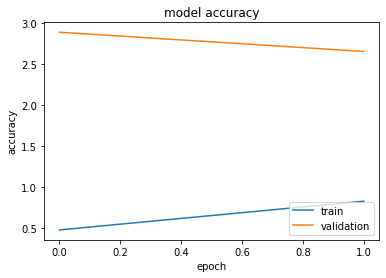

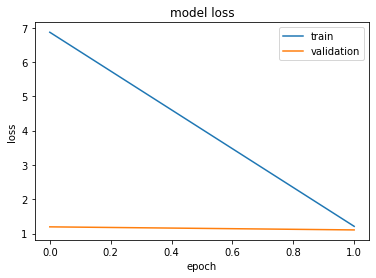

Train on 64 samples, validate on 64 samples
Epoch 1/2
21/21 [==============================] - 18s 873ms/step - loss: 2.5618 - accuracy: 0.7740 - val_loss: 0.3877 - val_accuracy: 2.6992
Epoch 2/2
21/21 [==============================] - 17s 829ms/step - loss: 0.6721 - accuracy: 0.8546 - val_loss: 0.2287 - val_accuracy: 4.0039


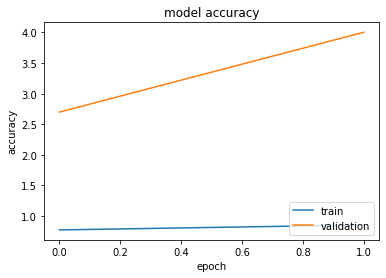

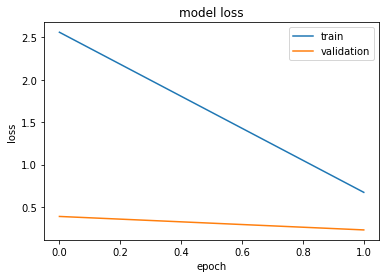

Started prediction for tkey:  train
	 goal_prediction at  1579041628.057815
	 traj_prediction 1579041726.1900337
		At pred_ind  0
		At pred_ind  1
		At pred_ind  2
		At pred_ind  3
		At pred_ind  4
		At pred_ind  5
		At pred_ind  6
		At pred_ind  7
		At pred_ind  8
		At pred_ind  9
		At pred_ind  10
		At pred_ind  11
		At pred_ind  12
		At pred_ind  13
		At pred_ind  14
		At pred_ind  15
		At pred_ind  16
		At pred_ind  17
		At pred_ind  18
		At pred_ind  19
		At pred_ind  20
		At pred_ind  21
		At pred_ind  22
		At pred_ind  23
		At pred_ind  24
		At pred_ind  25
		At pred_ind  26
		At pred_ind  27
		At pred_ind  28
		At pred_ind  29
		At pred_ind  30
		At pred_ind  31
		At pred_ind  32
		At pred_ind  33
		At pred_ind  34
		At pred_ind  35
		At pred_ind  36
		At pred_ind  37
		At pred_ind  38
		At pred_ind  39
		At pred_ind  40
		At pred_ind  41
		At pred_ind  42
		At pred_ind  43
		At pred_ind  44
		At pred_ind  45
		At pred_ind  46
		At pred_ind  47
		At pred_ind  48
		At pred_ind  

		At pred_ind  433
		At pred_ind  434
		At pred_ind  435
		At pred_ind  436
		At pred_ind  437
		At pred_ind  438
		At pred_ind  439
		At pred_ind  440
		At pred_ind  441
		At pred_ind  442
		At pred_ind  443
		At pred_ind  444
		At pred_ind  445
		At pred_ind  446
		At pred_ind  447
		At pred_ind  448
		At pred_ind  449
		At pred_ind  450
		At pred_ind  451
		At pred_ind  452
		At pred_ind  453
		At pred_ind  454
		At pred_ind  455
		At pred_ind  456
		At pred_ind  457
		At pred_ind  458
		At pred_ind  459
		At pred_ind  460
		At pred_ind  461
		At pred_ind  462
		At pred_ind  463
		At pred_ind  464
		At pred_ind  465
		At pred_ind  466
		At pred_ind  467
		At pred_ind  468
		At pred_ind  469
		At pred_ind  470
		At pred_ind  471
		At pred_ind  472
		At pred_ind  473
		At pred_ind  474
		At pred_ind  475
		At pred_ind  476
		At pred_ind  477
		At pred_ind  478
		At pred_ind  479
		At pred_ind  480
		At pred_ind  481
		At pred_ind  482
		At pred_ind  483
		At pred_ind  484
		At pred_in

		At pred_ind  865
		At pred_ind  866
		At pred_ind  867
		At pred_ind  868
		At pred_ind  869
		At pred_ind  870
		At pred_ind  871
		At pred_ind  872
		At pred_ind  873
		At pred_ind  874
		At pred_ind  875
		At pred_ind  876
		At pred_ind  877
		At pred_ind  878
		At pred_ind  879
		At pred_ind  880
		At pred_ind  881
		At pred_ind  882
		At pred_ind  883
		At pred_ind  884
		At pred_ind  885
		At pred_ind  886
		At pred_ind  887
		At pred_ind  888
		At pred_ind  889
		At pred_ind  890
		At pred_ind  891
		At pred_ind  892
		At pred_ind  893
		At pred_ind  894
		At pred_ind  895
		At pred_ind  896
		At pred_ind  897
		At pred_ind  898
		At pred_ind  899
		At pred_ind  900
		At pred_ind  901
		At pred_ind  902
		At pred_ind  903
		At pred_ind  904
		At pred_ind  905
		At pred_ind  906
		At pred_ind  907
		At pred_ind  908
		At pred_ind  909
		At pred_ind  910
		At pred_ind  911
		At pred_ind  912
		At pred_ind  913
		At pred_ind  914
		At pred_ind  915
		At pred_ind  916
		At pred_in

		At pred_ind  1282
		At pred_ind  1283
		At pred_ind  1284
		At pred_ind  1285
		At pred_ind  1286
		At pred_ind  1287
		At pred_ind  1288
		At pred_ind  1289
		At pred_ind  1290
		At pred_ind  1291
		At pred_ind  1292
		At pred_ind  1293
		At pred_ind  1294
		At pred_ind  1295
		At pred_ind  1296
		At pred_ind  1297
		At pred_ind  1298
		At pred_ind  1299
		At pred_ind  1300
		At pred_ind  1301
		At pred_ind  1302
		At pred_ind  1303
		At pred_ind  1304
		At pred_ind  1305
		At pred_ind  1306
		At pred_ind  1307
		At pred_ind  1308
		At pred_ind  1309
		At pred_ind  1310
		At pred_ind  1311
		At pred_ind  1312
		At pred_ind  1313
		At pred_ind  1314
		At pred_ind  1315
		At pred_ind  1316
		At pred_ind  1317
		At pred_ind  1318
		At pred_ind  1319
		At pred_ind  1320
		At pred_ind  1321
		At pred_ind  1322
		At pred_ind  1323
		At pred_ind  1324
		At pred_ind  1325
		At pred_ind  1326
		At pred_ind  1327
		At pred_ind  1328
		At pred_ind  1329
		At pred_ind  1330
		At pred_ind  1331


		At pred_ind  344
		At pred_ind  345
		At pred_ind  346
		At pred_ind  347
		At pred_ind  348
		At pred_ind  349
		At pred_ind  350
		At pred_ind  351
		At pred_ind  352
		At pred_ind  353
		At pred_ind  354
		At pred_ind  355
		At pred_ind  356
		At pred_ind  357
		At pred_ind  358
		At pred_ind  359
		At pred_ind  360
		At pred_ind  361
		At pred_ind  362
		At pred_ind  363
		At pred_ind  364
		At pred_ind  365
		At pred_ind  366
		At pred_ind  367
		At pred_ind  368
		At pred_ind  369
		At pred_ind  370
		At pred_ind  371
		At pred_ind  372
		At pred_ind  373
		At pred_ind  374
		At pred_ind  375
		At pred_ind  376
		At pred_ind  377
		At pred_ind  378
		At pred_ind  379
		At pred_ind  380
		At pred_ind  381
		At pred_ind  382
		At pred_ind  383
		At pred_ind  384
		At pred_ind  385
		At pred_ind  386
		At pred_ind  387
		At pred_ind  388
		At pred_ind  389
		At pred_ind  390
		At pred_ind  391
		At pred_ind  392
		At pred_ind  393
		At pred_ind  394
		At pred_ind  395
		At pred_in

		At pred_ind  776
		At pred_ind  777
		At pred_ind  778
		At pred_ind  779
		At pred_ind  780
		At pred_ind  781
		At pred_ind  782
		At pred_ind  783
		At pred_ind  784
		At pred_ind  785
		At pred_ind  786
		At pred_ind  787
		At pred_ind  788
		At pred_ind  789
		At pred_ind  790
		At pred_ind  791
		At pred_ind  792
		At pred_ind  793
		At pred_ind  794
		At pred_ind  795
		At pred_ind  796
		At pred_ind  797
		At pred_ind  798
		At pred_ind  799
		At pred_ind  800
		At pred_ind  801
		At pred_ind  802
		At pred_ind  803
		At pred_ind  804
		At pred_ind  805
		At pred_ind  806
		At pred_ind  807
		At pred_ind  808
		At pred_ind  809
		At pred_ind  810
		At pred_ind  811
		At pred_ind  812
		At pred_ind  813
		At pred_ind  814
		At pred_ind  815
		At pred_ind  816
		At pred_ind  817
		At pred_ind  818
		At pred_ind  819
		At pred_ind  820
		At pred_ind  821
		At pred_ind  822
		At pred_ind  823
		At pred_ind  824
		At pred_ind  825
		At pred_ind  826
		At pred_ind  827
		At pred_in

		At pred_ind  1199
		At pred_ind  1200
		At pred_ind  1201
		At pred_ind  1202
		At pred_ind  1203
		At pred_ind  1204
		At pred_ind  1205
		At pred_ind  1206
		At pred_ind  1207
		At pred_ind  1208
		At pred_ind  1209
		At pred_ind  1210
		At pred_ind  1211
		At pred_ind  1212
		At pred_ind  1213
		At pred_ind  1214
		At pred_ind  1215
		At pred_ind  1216
		At pred_ind  1217
		At pred_ind  1218
		At pred_ind  1219
		At pred_ind  1220
		At pred_ind  1221
		At pred_ind  1222
		At pred_ind  1223
		At pred_ind  1224
		At pred_ind  1225
		At pred_ind  1226
		At pred_ind  1227
		At pred_ind  1228
		At pred_ind  1229
		At pred_ind  1230
		At pred_ind  1231
		At pred_ind  1232
		At pred_ind  1233
		At pred_ind  1234
		At pred_ind  1235
		At pred_ind  1236
		At pred_ind  1237
		At pred_ind  1238
		At pred_ind  1239
		At pred_ind  1240
		At pred_ind  1241
		At pred_ind  1242
		At pred_ind  1243
		At pred_ind  1244
		At pred_ind  1245
		At pred_ind  1246
		At pred_ind  1247
		At pred_ind  1248


		At pred_ind  265
		At pred_ind  266
		At pred_ind  267
		At pred_ind  268
		At pred_ind  269
		At pred_ind  270
		At pred_ind  271
		At pred_ind  272
		At pred_ind  273
		At pred_ind  274
		At pred_ind  275
		At pred_ind  276
		At pred_ind  277
		At pred_ind  278
		At pred_ind  279
		At pred_ind  280
		At pred_ind  281
		At pred_ind  282
		At pred_ind  283
		At pred_ind  284
		At pred_ind  285
		At pred_ind  286
		At pred_ind  287
		At pred_ind  288
		At pred_ind  289
		At pred_ind  290
		At pred_ind  291
		At pred_ind  292
		At pred_ind  293
		At pred_ind  294
		At pred_ind  295
		At pred_ind  296
		At pred_ind  297
		At pred_ind  298
		At pred_ind  299
		At pred_ind  300
		At pred_ind  301
		At pred_ind  302
		At pred_ind  303
		At pred_ind  304
		At pred_ind  305
		At pred_ind  306
		At pred_ind  307
		At pred_ind  308
		At pred_ind  309
		At pred_ind  310
		At pred_ind  311
		At pred_ind  312
		At pred_ind  313
		At pred_ind  314
		At pred_ind  315
		At pred_ind  316
		At pred_in

		At pred_ind  697
		At pred_ind  698
		At pred_ind  699
		At pred_ind  700
		At pred_ind  701
		At pred_ind  702
		At pred_ind  703
		At pred_ind  704
		At pred_ind  705
		At pred_ind  706
		At pred_ind  707
		At pred_ind  708
		At pred_ind  709
		At pred_ind  710
		At pred_ind  711
		At pred_ind  712
		At pred_ind  713
		At pred_ind  714
		At pred_ind  715
		At pred_ind  716
		At pred_ind  717
		At pred_ind  718
		At pred_ind  719
		At pred_ind  720
		At pred_ind  721
		At pred_ind  722
		At pred_ind  723
		At pred_ind  724
		At pred_ind  725
		At pred_ind  726
		At pred_ind  727
		At pred_ind  728
		At pred_ind  729
		At pred_ind  730
		At pred_ind  731
		At pred_ind  732
		At pred_ind  733
		At pred_ind  734
		At pred_ind  735
		At pred_ind  736
		At pred_ind  737
		At pred_ind  738
		At pred_ind  739
		At pred_ind  740
		At pred_ind  741
		At pred_ind  742
		At pred_ind  743
		At pred_ind  744
		At pred_ind  745
		At pred_ind  746
		At pred_ind  747
		At pred_ind  748
		At pred_in

		At pred_ind  1123
		At pred_ind  1124
		At pred_ind  1125
		At pred_ind  1126
		At pred_ind  1127
		At pred_ind  1128
		At pred_ind  1129
		At pred_ind  1130
		At pred_ind  1131
		At pred_ind  1132
		At pred_ind  1133
		At pred_ind  1134
		At pred_ind  1135
		At pred_ind  1136
		At pred_ind  1137
		At pred_ind  1138
		At pred_ind  1139
		At pred_ind  1140
		At pred_ind  1141
		At pred_ind  1142
		At pred_ind  1143
		At pred_ind  1144
		At pred_ind  1145
		At pred_ind  1146
		At pred_ind  1147
		At pred_ind  1148
		At pred_ind  1149
		At pred_ind  1150
		At pred_ind  1151
		At pred_ind  1152
		At pred_ind  1153
		At pred_ind  1154
		At pred_ind  1155
		At pred_ind  1156
		At pred_ind  1157
		At pred_ind  1158
		At pred_ind  1159
		At pred_ind  1160
		At pred_ind  1161
		At pred_ind  1162
		At pred_ind  1163
		At pred_ind  1164
		At pred_ind  1165
		At pred_ind  1166
		At pred_ind  1167
		At pred_ind  1168
		At pred_ind  1169
		At pred_ind  1170
		At pred_ind  1171
		At pred_ind  1172


		At pred_ind  183
		At pred_ind  184
		At pred_ind  185
		At pred_ind  186
		At pred_ind  187
		At pred_ind  188
		At pred_ind  189
		At pred_ind  190
		At pred_ind  191
		At pred_ind  192
		At pred_ind  193
		At pred_ind  194
		At pred_ind  195
		At pred_ind  196
		At pred_ind  197
		At pred_ind  198
		At pred_ind  199
		At pred_ind  200
		At pred_ind  201
		At pred_ind  202
		At pred_ind  203
		At pred_ind  204
		At pred_ind  205
		At pred_ind  206
		At pred_ind  207
		At pred_ind  208
		At pred_ind  209
		At pred_ind  210
		At pred_ind  211
		At pred_ind  212
		At pred_ind  213
		At pred_ind  214
		At pred_ind  215
		At pred_ind  216
		At pred_ind  217
		At pred_ind  218
		At pred_ind  219
		At pred_ind  220
		At pred_ind  221
		At pred_ind  222
		At pred_ind  223
		At pred_ind  224
		At pred_ind  225
		At pred_ind  226
		At pred_ind  227
		At pred_ind  228
		At pred_ind  229
		At pred_ind  230
		At pred_ind  231
		At pred_ind  232
		At pred_ind  233
		At pred_ind  234
		At pred_in

		At pred_ind  617
		At pred_ind  618
		At pred_ind  619
		At pred_ind  620
		At pred_ind  621
		At pred_ind  622
		At pred_ind  623
		At pred_ind  624
		At pred_ind  625
		At pred_ind  626
		At pred_ind  627
		At pred_ind  628
		At pred_ind  629
		At pred_ind  630
		At pred_ind  631
		At pred_ind  632
		At pred_ind  633
		At pred_ind  634
		At pred_ind  635
		At pred_ind  636
		At pred_ind  637
		At pred_ind  638
		At pred_ind  639
		At pred_ind  640
		At pred_ind  641
		At pred_ind  642
		At pred_ind  643
		At pred_ind  644
		At pred_ind  645
		At pred_ind  646
		At pred_ind  647
		At pred_ind  648
		At pred_ind  649
		At pred_ind  650
		At pred_ind  651
		At pred_ind  652
		At pred_ind  653
		At pred_ind  654
		At pred_ind  655
		At pred_ind  656
		At pred_ind  657
		At pred_ind  658
		At pred_ind  659
		At pred_ind  660
		At pred_ind  661
		At pred_ind  662
		At pred_ind  663
		At pred_ind  664
		At pred_ind  665
		At pred_ind  666
		At pred_ind  667
		At pred_ind  668
		At pred_in

		At pred_ind  1046
		At pred_ind  1047
		At pred_ind  1048
		At pred_ind  1049
		At pred_ind  1050
		At pred_ind  1051
		At pred_ind  1052
		At pred_ind  1053
		At pred_ind  1054
		At pred_ind  1055
		At pred_ind  1056
		At pred_ind  1057
		At pred_ind  1058
		At pred_ind  1059
		At pred_ind  1060
		At pred_ind  1061
		At pred_ind  1062
		At pred_ind  1063
		At pred_ind  1064
		At pred_ind  1065
		At pred_ind  1066
		At pred_ind  1067
		At pred_ind  1068
		At pred_ind  1069
		At pred_ind  1070
		At pred_ind  1071
		At pred_ind  1072
		At pred_ind  1073
		At pred_ind  1074
		At pred_ind  1075
		At pred_ind  1076
		At pred_ind  1077
		At pred_ind  1078
		At pred_ind  1079
		At pred_ind  1080
		At pred_ind  1081
		At pred_ind  1082
		At pred_ind  1083
		At pred_ind  1084
		At pred_ind  1085
		At pred_ind  1086
		At pred_ind  1087
		At pred_ind  1088
		At pred_ind  1089
		At pred_ind  1090
		At pred_ind  1091
		At pred_ind  1092
		At pred_ind  1093
		At pred_ind  1094
		At pred_ind  1095


ValueError: too many values to unpack (expected 2)

In [5]:
#  TODO: Vijay

# Construct the evaluation datasets.
MODE = 'TRAIN' # 'TRAIN' or 'LOAD'
res_filename = 'model_comparison_dict.pkl'

tffiles_to_process = glob.glob('../examples/bags/*.tfrecord')
train_sets, test_sets = build_train_test_splits(tffiles_to_process, num_tf_folds=5)

# Build the model bank.
#models = [EKF_CV_MODEL(x_init=np.zeros(5), P_init=np.eye(5), R=np.diag([1e-3]*3), dt=0.1)]
#names =  ['EKF_CV']

models = []
names  = []

# Create saving directories.
if not os.path.exists('./model'):
    os.makedirs('./model')
if not os.path.exists('./results'):
    os.makedirs('./results')

# Build Trajectory Model
# history_shape = train_sets[0]['history_traj_data'].shape
# goal_position_shape = train_sets[0]['goal_position'].shape
# one_hot_goal_shape = train_sets[0]['one_hot_goal'].shape
# future_shape = train_sets[0]['future_traj_data'].shape
# Hard coded for now, need to make this more robust:
history_shape       = (None, 5, 3)
goal_position_shape = (None, 32*3)
one_hot_goal_shape  = (None, 32+1)
future_shape        = (None, 20, 2)
image_input_shape = (5,650,200,3)
hidden_dim = 100
top_k_goal = [0,1,2]


for gamma in [0.1]:
    for beta in [0.1]:
# for gamma in [0.001, 0.1, 1.0]:
#     for beta in [0.001, 0.1, 1.0]:
        models.append(
            CombinedLSTM(history_shape,
                         goal_position_shape,
                         image_input_shape,
                         one_hot_goal_shape,
                         future_shape,
                         hidden_dim,
                         beta=beta,
                         gamma=gamma,
                         use_goal_info=True)
        )
    
        names.append('LSTM_b%.3f_g%.3f' % (beta, gamma)) # ground truth goal, anyone can be used for traj LSTM

models.append(
    CombinedLSTM(history_shape,
                 goal_position_shape,
                 image_input_shape,
                 one_hot_goal_shape,
                 future_shape,
                 hidden_dim,
                 beta=beta,
                 gamma=gamma,
                 use_goal_info=False)
) # no goal provided, beta gamma irrelevant, don't use for goal classification

names.append('LSTM_no_goal')

model_res_dict = {} # same indexing/length as names/models
if MODE is 'TRAIN':
    for name, model in zip(names, models):
        metric_dict = {}
        metric_dict['train'] = {'N_instances'   : [],
                                'traj_dist_vs_N': [],   # no goal
                                'wtraj_dist_vs_N': [],  # weighted, multimodal
                                'gtraj_dist_vs_N': [],  # gt
                                'goal_top_1_acc': [], 
                                'goal_top_3_acc': [],
                                'goal_top_5_acc': [],
                                'goal_entropy'  : []}
        metric_dict['test']  = {'N_instances'   : [],
                                'traj_dist_vs_N': [],   # no goal
                                'wtraj_dist_vs_N': [],  # weighted, multimodal
                                'gtraj_dist_vs_N': [],  # gt
                                'goal_top_1_acc': [], 
                                'goal_top_3_acc': [],
                                'goal_top_5_acc': [],
                                'goal_entropy'  : []}

        for i_fold, (train_set, test_set) in enumerate(zip(train_sets, test_sets)):
            
            print('Training %s, Fold %d' % (name, i_fold))
            if 'EKF' in name:
                model.fit(train_set, test_set)
            else:
                model.fit(train_set, test_set, verbose=1, num_epochs=2)
                
            #model.fit(train_set, test_set)
            model.save('./model/%s_fold%d' % (name, i_fold))

            for tkey, tset in zip(['train', 'test'], [train_set, test_set]):
                print('Started prediction for tkey: ', tkey)
                goal_pred, goal_gt, traj_pred_dict, traj_gt = model.predict(tset) # either no goal or ground truth
                N_instances = goal_pred.shape[0]
                
                if 'no_goal' in name or 'EKF_CV' in name:
                    # just populate the traj_dist_vs_N
                    meand, mind, maxd = dist_by_timestep(traj_pred_dict, traj_gt[:,:,:2])
                    metric_dict[tkey]['traj_dist_vs_N'].append(meand)
                else:
                    meand, mind, maxd = dist_by_timestep(traj_pred_dict, traj_gt[:,:,:2])
                    metric_dict[tkey]['gtraj_dist_vs_N'].append(meand)
                    
                    goal_pred, goal_gt, traj_pred_dict, traj_gt = model.predict(tset, top_k_goal)
                    wmeand = weighted_dist_by_timestep(goal_pred, traj_pred_dict, traj_gt[:,:,:2])
                    metric_dict[tkey]['wtraj_dist_vs_N'].append(wmeand)
                    # populate gtraj_dist_vs_N (gt)
                    # and do multimodal
                
                t1 = top_k_accuracy(goal_pred, goal_gt, k=1)
                t3 = top_k_accuracy(goal_pred, goal_gt, k=3)
                t5 = top_k_accuracy(goal_pred, goal_gt, k=5)

                ment = mean_entropy(goal_pred)
                metric_dict[tkey]['N_instances'].append(N_instances)
                metric_dict[tkey]['goal_top_1_acc'].append(t1)
                metric_dict[tkey]['goal_top_3_acc'].append(t3)
                metric_dict[tkey]['goal_top_5_acc'].append(t5)
                metric_dict[tkey]['goal_entropy'].append(ment)

                # TODO: save predictions/labels?
            if i_fold == 0:
                break
                

        model_res_dict[name] = metric_dict
        print(name, ' finished.')

    # save the model_res_dict to ./results
    filename = 'model_comparison_dict.pkl'
    pickle.dump(model_res_dict, open('./results/%s' % res_filename, 'wb'))
elif MODE is 'LOAD':
    # TODO: maybe load models if needed?
    model_res_dict = pickle.load(open('./results/%s' % res_filename, 'rb'))
else:
    raise ValueError("Invalid mode!")

### Analysis and Visualization

In [ ]:
# TODO: visualize the snippets.  Needs to be done with tfrecord.
'''
# Get the data
pklfiles_to_process = glob.glob('./dataset/*.pkl')
pklfiles_to_process.sort()
print('Found %d pkl files: %s' % (len(pklfiles_to_process), pklfiles_to_process))

file_num = 0

pklfile = pklfiles_to_process[file_num]

vtest_set  = {"history_traj_data" : None,
             "future_traj_data"  : None,
             "goal_position"     : None,
             "one_hot_goal"      : None}
vtest_set_kf  = {"history_traj_data" : None,
             "future_traj_data"  : None,
             "goal_position"     : None,
             "one_hot_goal"      : None}

vtest_set['history_traj_data'], vtest_set['future_traj_data'], vtest_set['goal_position'], vtest_set['one_hot_goal'], traj_idx = extract_data(pklfile, full_traj=True, crop_traj=True)
vtest_set_kf['history_traj_data'], vtest_set_kf['future_traj_data'], vtest_set_kf['goal_position'], vtest_set_kf['one_hot_goal'], traj_idx_kf = extract_data(pklfile, full_traj=True, crop_traj=False)

for name, model in zip(names, models):
    if 'EKF_CV' in name:
        goal_pred, traj_pred_dict = model.predict(vtest_set_kf)
    elif 'no_goal' in name:
        continue
    else:
        goal_pred, traj_pred_dict = model.predict(vtest_set, top_k_goal=top_k_goal)
        
    sup_plot(name, vtest_set, traj_idx, goal_pred, traj_pred_dict, limit=2)
'''

In [ ]:
# PLOT 1: timestep vs. mean distance error
import pandas as pd
import seaborn as sns
data_list = []
timesteps = np.arange(20) # TODO: hard coded for now, change later.

for model in model_res_dict.keys():
    for split in model_res_dict[model].keys(): 
        # train/test
        if 'no_goal' in model:
            name = model
            traj_dist_vs_N = model_res_dict[model][split]['traj_dist_vs_N']
        elif 'EKF' in model:
            name = model
            traj_dist_vs_N = model_res_dict[model][split]['traj_dist_vs_N']
            # hack to only get ground truth goal based traj. pred once
        elif 'b0.100_g0.100' in model:
            name = 'LSTM_gt_goal'
            traj_dist_vs_N = model_res_dict[model][split]['gtraj_dist_vs_N']
        else:
            continue
    
        for i_fold, td in enumerate(traj_dist_vs_N):
            for j_timestep, dist_timestep in enumerate(td):
                data_list.append([name, split, i_fold, j_timestep, dist_timestep])
            
traj_df = pd.DataFrame(data_list, columns=['Model', 'Split', 'Fold', 'Timestep', 'Distance Error'],dtype=float)
print(traj_df)

ax = sns.lineplot(x="Timestep", y="Distance Error", hue="Model", data=traj_df[traj_df.Split == 'test'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('Distance Error (m)')
plt.xticks(np.arange(0, 21, step=2))
plt.yticks(np.arange(0, 1.51, step=0.25))
plt.show()

ax = sns.lineplot(x="Timestep", y="Distance Error", hue="Model", data=traj_df[(traj_df.Split == 'test') & \
                                                                              (traj_df.Model != 'EKF_CV')])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('Distance Error (m)')
plt.xticks(np.arange(0, 21, step=2))
plt.yticks(np.arange(0, 1.51, step=0.25))
plt.show()

In [ ]:
# PLOT 2: timestep vs. weighted mean distance error
import pandas as pd
import seaborn as sns
data_list = []
timesteps = np.arange(20) # TODO: hard coded for now, change later.

for model in model_res_dict.keys():
    for split in model_res_dict[model].keys(): 
        # train/test
        if 'no_goal' in model:
            name = model
            traj_dist_vs_N = model_res_dict[model][split]['traj_dist_vs_N']
        elif 'EKF' in model:
            continue
        else:
            name = model
            traj_dist_vs_N = model_res_dict[model][split]['wtraj_dist_vs_N']  
            
        for i_fold, td in enumerate(traj_dist_vs_N):
            for j_timestep, dist_timestep in enumerate(td):
                data_list.append([name, split, i_fold, j_timestep, dist_timestep])

gtraj_dist_vs_N_test = model_res_dict['LSTM_b0.100_g0.100']['test'] ['gtraj_dist_vs_N'] 
for i_fold, td in enumerate(gtraj_dist_vs_N_test):
    for j_timestep, dist_timestep in enumerate(td):
        data_list.append(['LSTM_gt_goal', 'test', i_fold, j_timestep, dist_timestep])

gtraj_dist_vs_N_train = model_res_dict['LSTM_b0.100_g0.001']['train']['gtraj_dist_vs_N'] 
for i_fold, td in enumerate(gtraj_dist_vs_N_train):
    for j_timestep, dist_timestep in enumerate(td):
        data_list.append(['LSTM_gt_goal', 'train', i_fold, j_timestep, dist_timestep])
                
traj_df = pd.DataFrame(data_list, columns=['Model', 'Split', 'Fold', 'Timestep', 'Weighted Distance Error'],dtype=float)
traj_df_test = traj_df[traj_df.Split == 'test']
print(traj_df_test)

ax = sns.lineplot(x="Timestep", y="Weighted Distance Error", hue="Model", data=traj_df_test)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('Distance Error (m)')
plt.xticks(np.arange(0, 21, step=2))
plt.yticks(np.arange(0, 1.51, step=0.25))
plt.show()

ax = sns.lineplot(x="Timestep", y="Weighted Distance Error", hue="Model", data=traj_df_test[(traj_df.Model == 'LSTM_no_goal') | 
                                                                                            (traj_df.Model == 'LSTM_gt_goal')])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('Distance Error (m)')
plt.xticks(np.arange(0, 21, step=2))
plt.yticks(np.arange(0, 1.51, step=0.25))
plt.show()

In [ ]:
# PLOT 3: Top K accuracy
import pandas as pd
import seaborn as sns
data_list = []
# timesteps = np.arange(20) # TODO: hard coded for now, change later.

for model in model_res_dict.keys():
    if 'no_goal' in model:
        continue
    for split in model_res_dict[model].keys():
        
        
        #train/test
        
        goal_top_1_acc = model_res_dict[model][split]['goal_top_1_acc']
        goal_top_3_acc = model_res_dict[model][split]['goal_top_3_acc']
        goal_top_5_acc = model_res_dict[model][split]['goal_top_5_acc']
#         goal_entropy   = model_res_dict[model][split]['goal_entropy']
        
        for i_fold, (t1, t3, t5) in enumerate(zip(goal_top_1_acc, 
                                                       goal_top_3_acc,
                                                       goal_top_5_acc)):
            data_list.append([model, split, i_fold, 1, t1])
            data_list.append([model, split, i_fold, 3, t3])
            data_list.append([model, split, i_fold, 5, t5])
            
goal_df = pd.DataFrame(data_list, columns=['Model', 'Split', 'Fold', 'k', 'Accuracy'],dtype=float)
goal_test_df = goal_df[goal_df.Split == 'test']

# Make a bar chart out of this.
ax = sns.barplot(x='k', y='Accuracy', hue='Model', data=goal_df.sort_values(by=['Model']))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()  


In [ ]:
# PLOT 4: Entropy
import pandas as pd
import seaborn as sns
data_list = []

for model in model_res_dict.keys():
    if 'no_goal' in model:
        continue
    for split in model_res_dict[model].keys():
        #train/test
        goal_entropy   = model_res_dict[model][split]['goal_entropy']
        
        for i_fold, ent in enumerate(goal_entropy):
            data_list.append([model, split, i_fold, ent])
            
goal_df = pd.DataFrame(data_list, columns=['Model', 'Split', 'Fold', 'Entropy'],dtype=float)
goal_test_df = goal_df[goal_df.Split == 'test']

# Make a bar chart out of this.
ax = sns.barplot(x='Model', y='Entropy', data=goal_df.sort_values(by=['Model']))
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation='vertical')
plt.show()  
